In [1]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')

x_train = df_train.drop(['label', 'view'], axis=1).values
y_train = df_train['label'].values
train_view = df_train['view'].values

x_test = df_test.drop(['label','view'], axis=1).values  
y_test = df_test['label'].values
test_view = df_test['view'].values

print(f"Kích thước của train và labels {x_train.shape} {y_train.shape}")
print(f"Kích thước của test và labels {x_test.shape} {y_test.shape}")

Kích thước của train và labels (11508, 18) (11508,)
Kích thước của test và labels (7672, 18) (7672,)


## Bulk processing

### RandomForest classifier

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# phân loại bằng RandomForest
mean_accuracy, y_pred = [], []

rf_model = RandomForestClassifier(
    n_estimators=300, max_depth=20, 
    min_samples_split=2,min_samples_leaf=1,
    max_features='sqrt',bootstrap=True
    )
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

mean_accuracy = (accuracy_score(y_test, y_pred))
print(f'Accuracy: {mean_accuracy * 100:.2f}%')

Accuracy: 89.36%


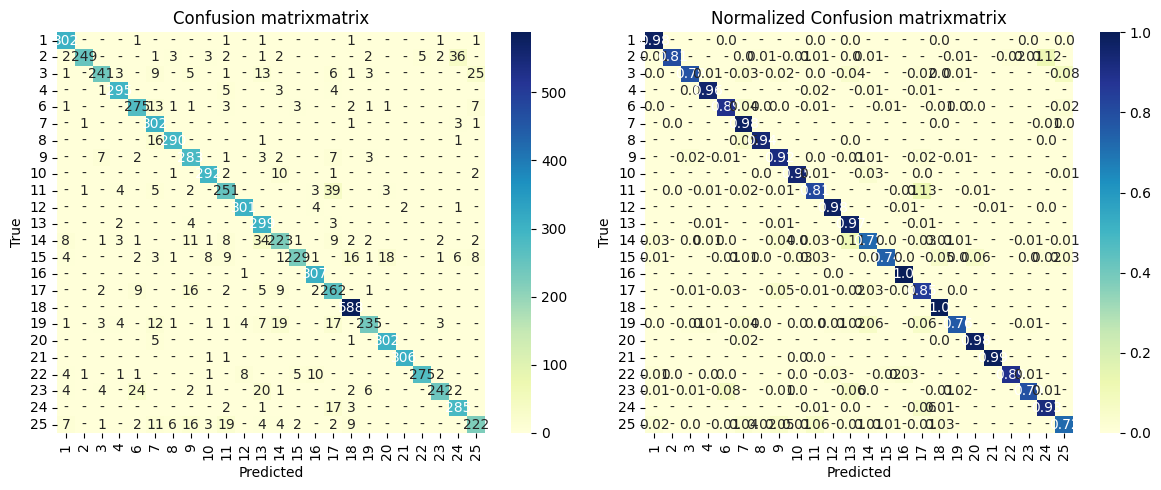

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Lọc các class thực tế và dự đoán có trong dữ liệu
class_names = list(range(1,26))
class_names = [cls for cls in class_names if cls in sorted(set(y_test) | set(y_pred))]

def draw_confusion_matrix(y_test, y_pred, class_names, title="Confusion Matrix"):
    # Tạo confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    annot_cm = np.where(cm == 0, "-", cm)
    annot_cm_norm = np.where(cm_normalized == 0, "-", np.round(cm_normalized, 2))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 hàng, 2 cột

    # Vẽ confusion matrix gốc
    sns.heatmap(
        cm, annot=annot_cm, fmt='', cmap='YlGnBu',  ax=axes[0],
        xticklabels=class_names, yticklabels=class_names)
    axes[0].set_title(title)
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # Vẽ confusion matrix đã chuẩn hóa
    sns.heatmap(
        cm_normalized, annot=annot_cm_norm, fmt='', cmap='YlGnBu',  ax=axes[1],
        xticklabels=class_names, yticklabels=class_names
    )
    axes[1].set_title(f'Normalized {title}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
        
draw_confusion_matrix(y_test, y_pred, class_names, 'Confusion matrixmatrix') # OKE

Độ chính xác với 1 thành phần: 12.60%
Độ chính xác với 2 thành phần: 25.26%
Độ chính xác với 3 thành phần: 43.44%
Độ chính xác với 4 thành phần: 57.14%
Độ chính xác với 5 thành phần: 65.52%
Độ chính xác với 6 thành phần: 71.01%
Độ chính xác với 7 thành phần: 77.08%
Độ chính xác với 8 thành phần: 83.38%
Độ chính xác với 9 thành phần: 86.30%
Độ chính xác với 10 thành phần: 89.09%
Độ chính xác với 11 thành phần: 90.03%
Độ chính xác với 12 thành phần: 91.04%
Độ chính xác với 13 thành phần: 91.85%
Độ chính xác với 14 thành phần: 91.98%
Độ chính xác với 15 thành phần: 92.82%
Độ chính xác với 16 thành phần: 92.56%
Độ chính xác với 17 thành phần: 93.21%
Độ chính xác với 18 thành phần: 93.60%


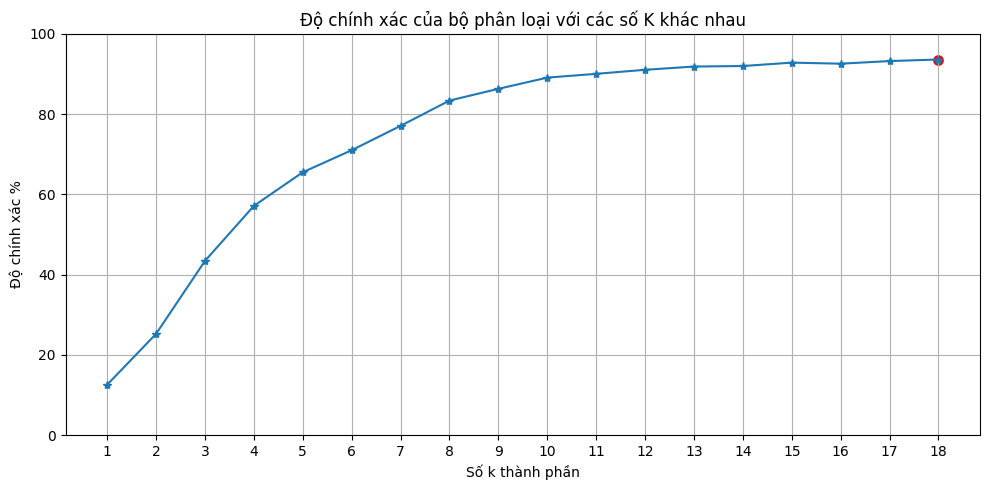

In [117]:
# Thử nghiệm xem accuracy thay đổi như thế nào khi thay đổi số k-thành phần
k_range = list(range(1,19)) # với k từ 1 đến 18
all_acc = []

for k in k_range:
    temp_x_train = x_train[:,0:k]
    temp_x_test = x_test[:,0:k]
    
    accuracy, y_pred = [], []

    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=20, 
        min_samples_split=2,min_samples_leaf=1,
        max_features='sqrt',bootstrap=True
        )
    rf_model.fit(temp_x_train, y_train)
    y_pred = rf_model.predict(temp_x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Độ chính xác với {k} thành phần: {accuracy * 100:.2f}%')
    all_acc.append(accuracy*100)
    

# Tìm vị trí có độ chính xác cao nhất
max_index = all_acc.index(max(all_acc))

# Làm nổi bật điểm tốt nhất
plt.figure(figsize=(10,5))
plt.title("Độ chính xác của bộ phân loại với các số K khác nhau")
plt.plot(k_range, all_acc, marker = '*', linestyle='-', linewidth = '1.5')

plt.scatter(k_range[max_index], all_acc[max_index], color='red', s=45, label=f'Max: {k_range[max_index]:.2f} at k={all_acc[max_index]}')

plt.xlabel('Số k thành phần')
plt.ylabel('Độ chính xác %')
plt.xticks(k_range)
plt.ylim((0,100))
plt.grid(True)
plt.tight_layout()
plt.show()

## Prediction based on views

In [7]:
# Chia kết quả đã dự đoán ra theo view để xem thử accuracy của các view có cao không
views = [0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]

x_train_by_view = [[] for _ in range(len(views))]
y_train_by_view = [[] for _ in range(len(views))]
x_test_by_view = [[] for _ in range(len(views))]
y_test_by_view = [[] for _ in range(len(views))]
y_pred_by_view = [[] for _ in range(len(views))]

for i in range(len(x_train)):
    if int(train_view[i]) in views:
        view_index = views.index(int(train_view[i]))
        x_train_by_view[view_index].append(x_train[i])
        y_train_by_view[view_index].append(y_train[i])

# Chuyển sang numpy array cho nhất quán với x_test_by_view, y_test_by_view
x_train_by_view = [np.array(arr) for arr in x_train_by_view]
y_train_by_view = [np.array(arr) for arr in y_train_by_view]

# Chia x_test ra làm 18 phần theo view để predict / huấn luyện + predictpredict
for i in range(len(x_test)):
    if int(test_view[i]) in views:
        view_index = views.index(int(test_view[i]))
        x_test_by_view[view_index].append(x_test[i])

x_test_by_view = [np.array(arr) for arr in x_test_by_view]

# Tạo ra list 18 view nhãn test để kiểm tra
for i in range(len(y_test)):
    if int(test_view[i]) in views:
        view_index = views.index(int(test_view[i]))
        y_test_by_view[view_index].append(y_test[i])

# Chia kết quả dự đoán ra theo view để so sánh
for i in range(len(y_pred)):
    if int(test_view[i]) in views:
        view_index = views.index(int(test_view[i]))
        y_pred_by_view[view_index].append(y_pred[i])

In [8]:
# Tách y_pred đã được dự đoán trước đó ra theo views để xem khả năng dự đoán của mô hình khi tất cả các views được gộp chung với nhau
print(f"Độ chính xác của mô hình khi gộp tất cả views lại với nhau và dự đoán")
allview_byview = []
for i in range(len(views)):
    acc = accuracy_score(y_pred_by_view[i], y_test_by_view[i])
    allview_byview.append(acc)
    print(f"Độ chính xác với góc {views[i]} là {acc*100:.2f}%")

# Huấn luyện lại mô hình mới và dự đoán từng views riêng
print("# Huấn luyện lại mô hình mới và dự đoán từng views riêng")
train_predict_acc = []
for i in range(len(views)):
    rf_model = RandomForestClassifier(
        n_estimators=200, max_depth=20, 
        min_samples_split=2,min_samples_leaf=1,
        max_features='sqrt',bootstrap=True
    )
    rf_model.fit(x_train_by_view[i], y_train_by_view[i])
    y_pred = rf_model.predict(x_test_by_view[i])
    accuracy = accuracy_score(y_test_by_view[i], y_pred)
    train_predict_acc.append(accuracy)
    print(f'Độ chính xác với góc {views[i]} là: {accuracy * 100:.2f}%')

Độ chính xác của mô hình khi gộp tất cả views lại với nhau và dự đoán
Độ chính xác với góc 0 là 90.92%
Độ chính xác với góc 18 là 92.86%
Độ chính xác với góc 36 là 88.69%
Độ chính xác với góc 54 là 87.35%
Độ chính xác với góc 72 là 90.62%
Độ chính xác với góc 90 là 87.20%
Độ chính xác với góc 108 là 84.08%
Độ chính xác với góc 126 là 86.46%
Độ chính xác với góc 144 là 87.65%
Độ chính xác với góc 162 là 91.67%
Độ chính xác với góc 180 là 94.05%
# Huấn luyện lại mô hình mới và dự đoán từng views riêng
Độ chính xác với góc 0 là: 92.56%
Độ chính xác với góc 18 là: 93.07%
Độ chính xác với góc 36 là: 82.74%
Độ chính xác với góc 54 là: 87.50%
Độ chính xác với góc 72 là: 89.14%
Độ chính xác với góc 90 là: 89.14%
Độ chính xác với góc 108 là: 82.74%
Độ chính xác với góc 126 là: 88.10%
Độ chính xác với góc 144 là: 88.24%
Độ chính xác với góc 162 là: 87.65%
Độ chính xác với góc 180 là: 94.94%


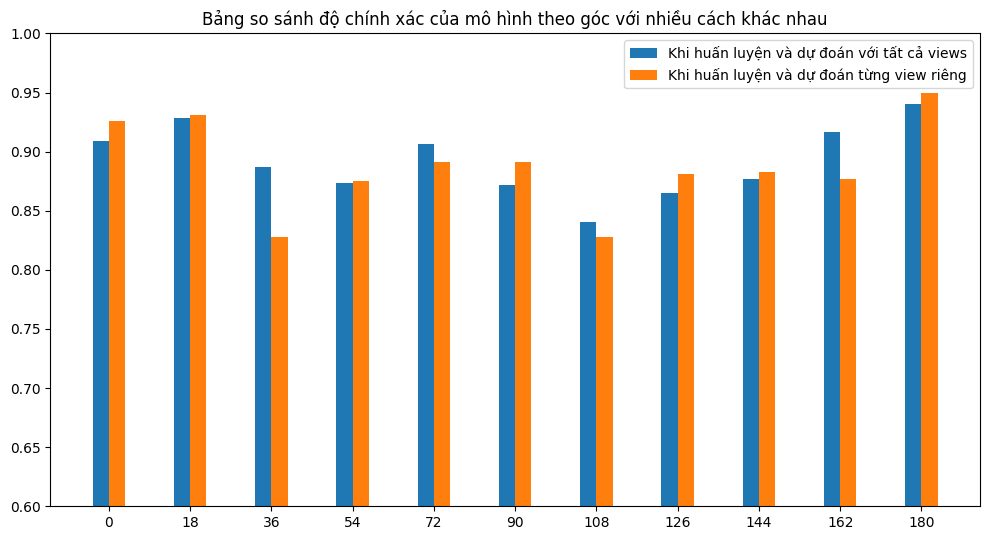

Accuracy trung bình khi huấn luyện/dự đoán với tất cả views 89.2316%
Accuracy trung bình khi huấn luyện/dự đoán từng views riêng 88.7096%


In [15]:
plt.figure(figsize=(10,5.5))

x = np.arange(len(views))
width = 0.2

plt.title('Bảng so sánh độ chính xác của mô hình theo góc với nhiều cách khác nhau')
plt.bar(x - width/2, allview_byview,width, label = 'Khi huấn luyện và dự đoán với tất cả views')
plt.bar(x + width/2, train_predict_acc,width, label = 'Khi huấn luyện và dự đoán từng view riêng')
plt.legend()
plt.xticks(x, views)
plt.ylim(0.6,1.0)
plt.tight_layout()
plt.show()

print(f"Accuracy trung bình khi huấn luyện/dự đoán với tất cả views {100*np.mean(allview_byview):.4f}%")
print(f"Accuracy trung bình khi huấn luyện/dự đoán từng views riêng {100*np.mean(train_predict_acc):.4f}%")

## Tách dữ liệu theo view để xem độ chính xác của mô hình

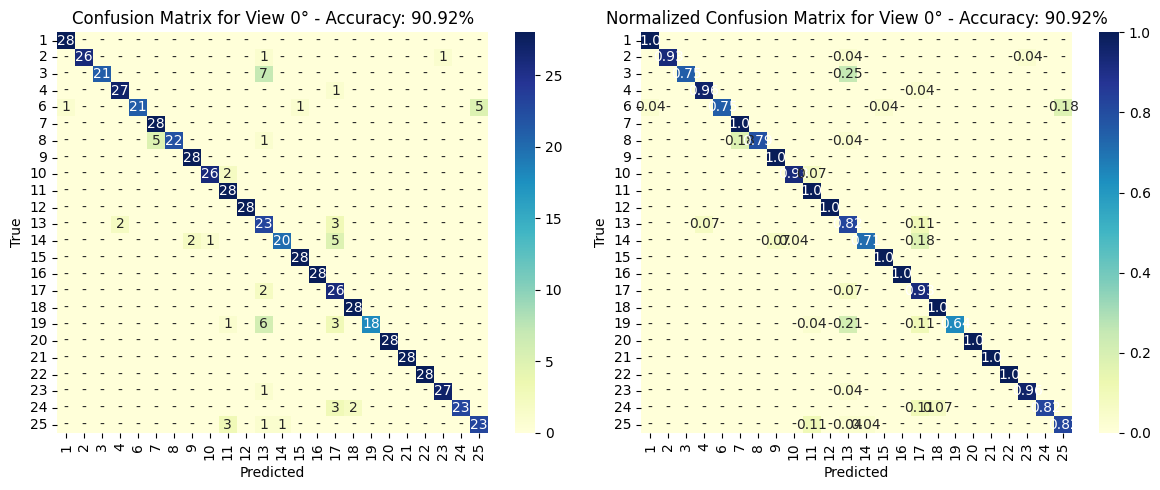

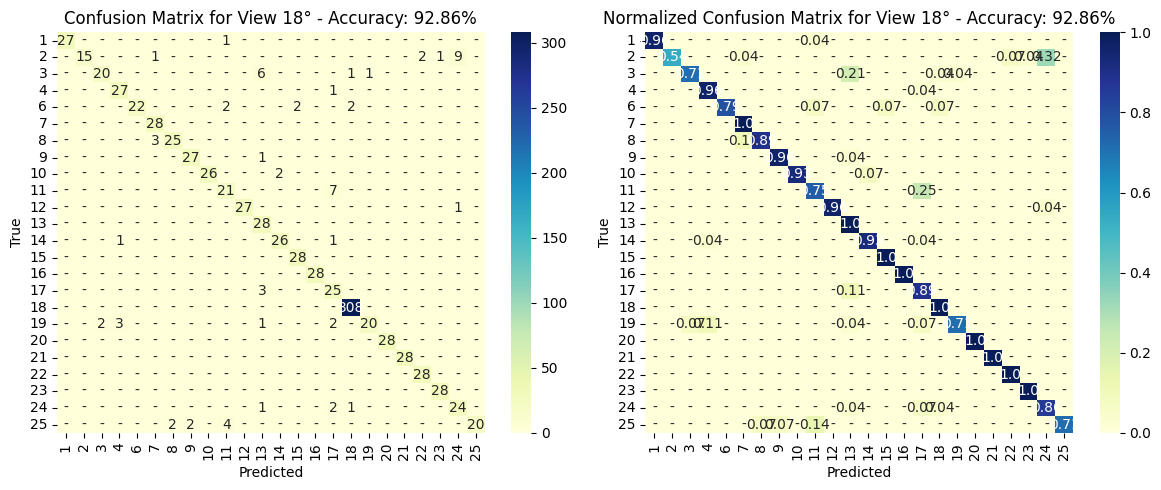

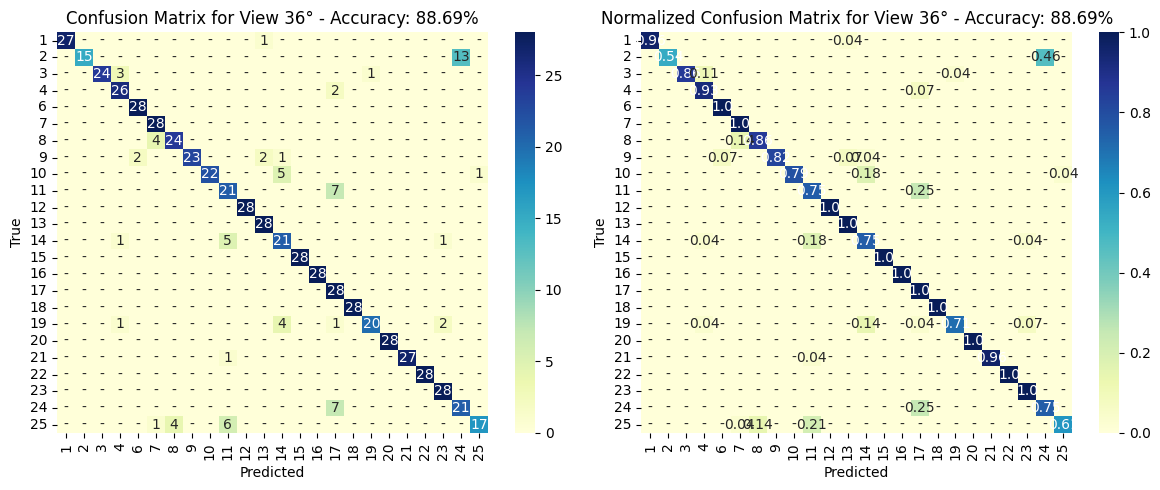

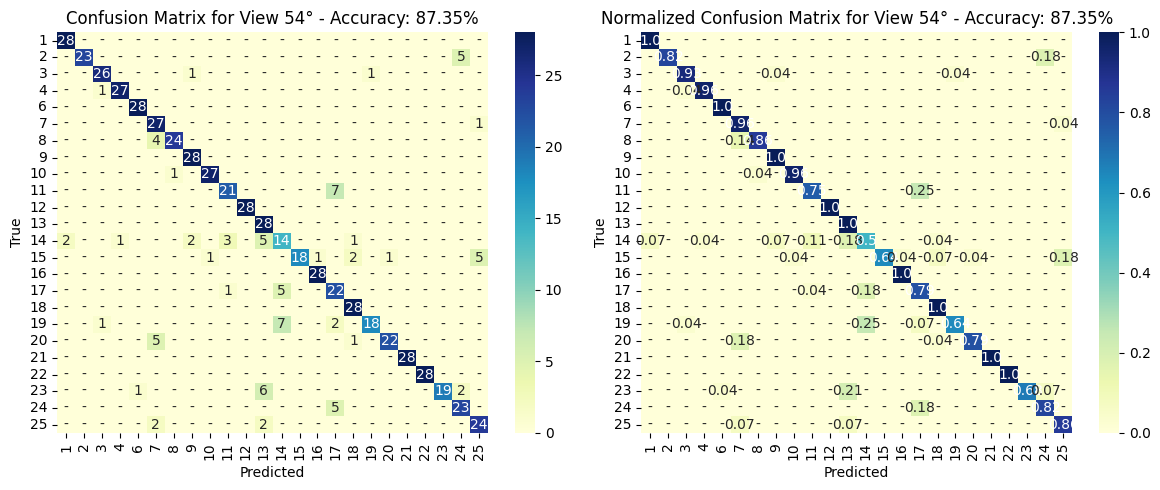

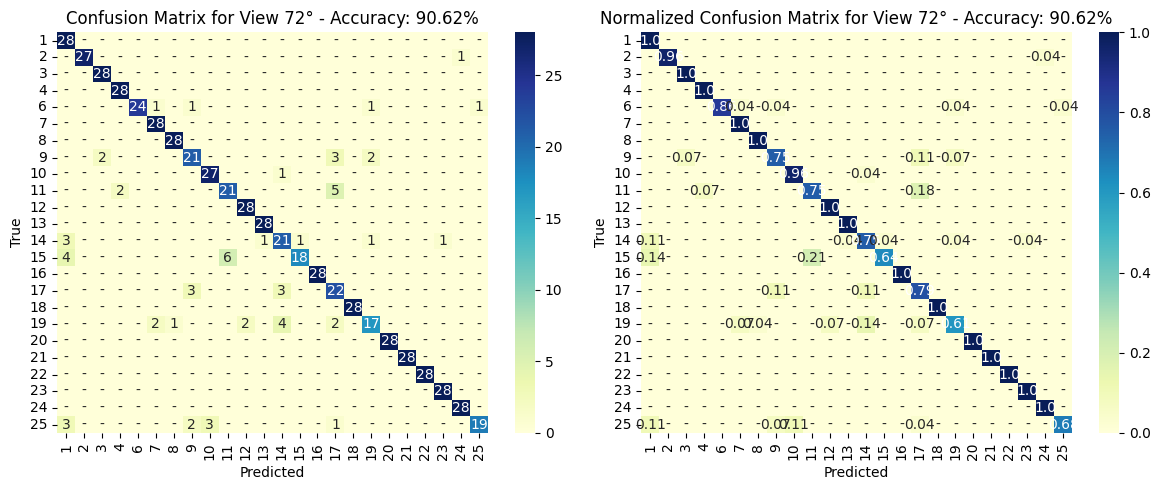

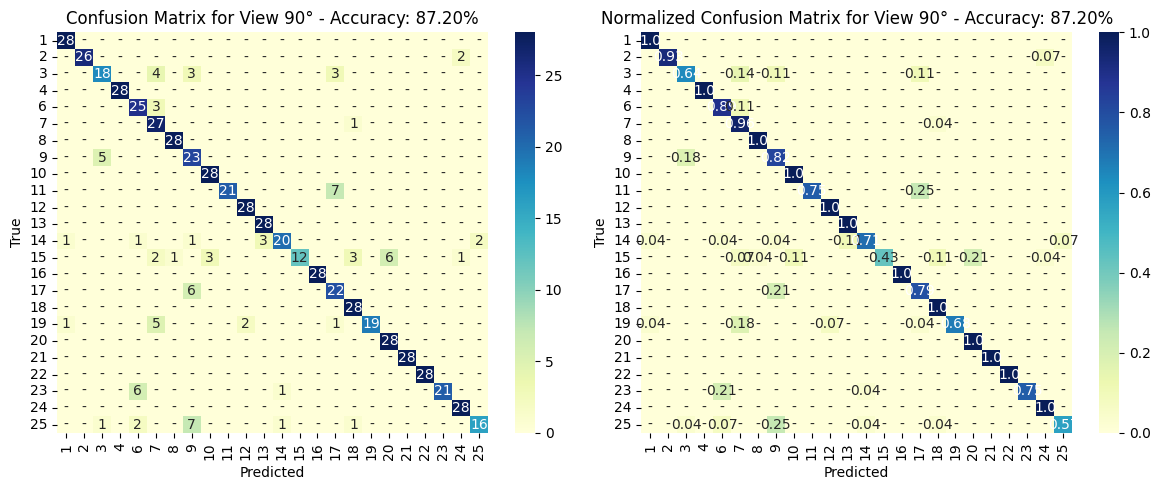

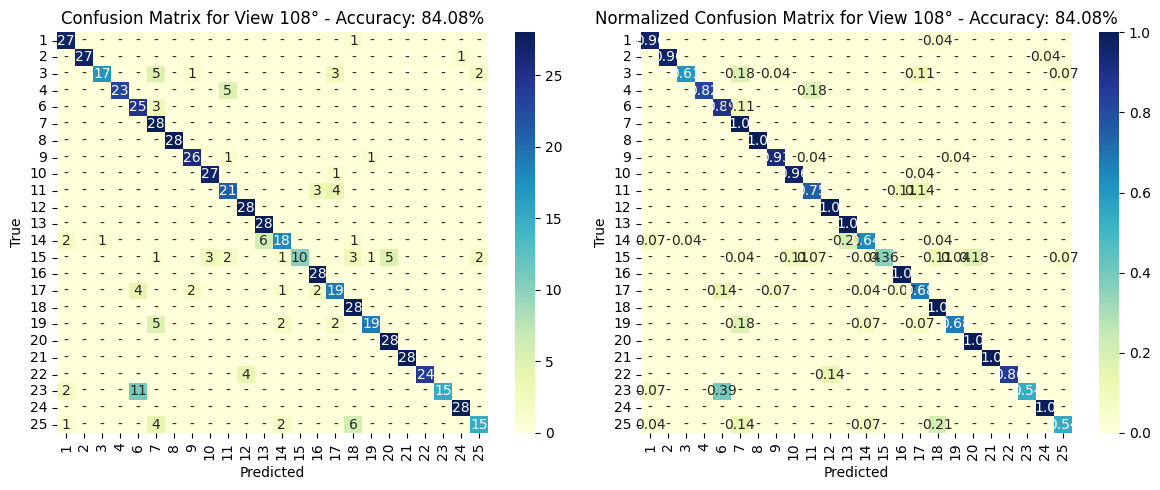

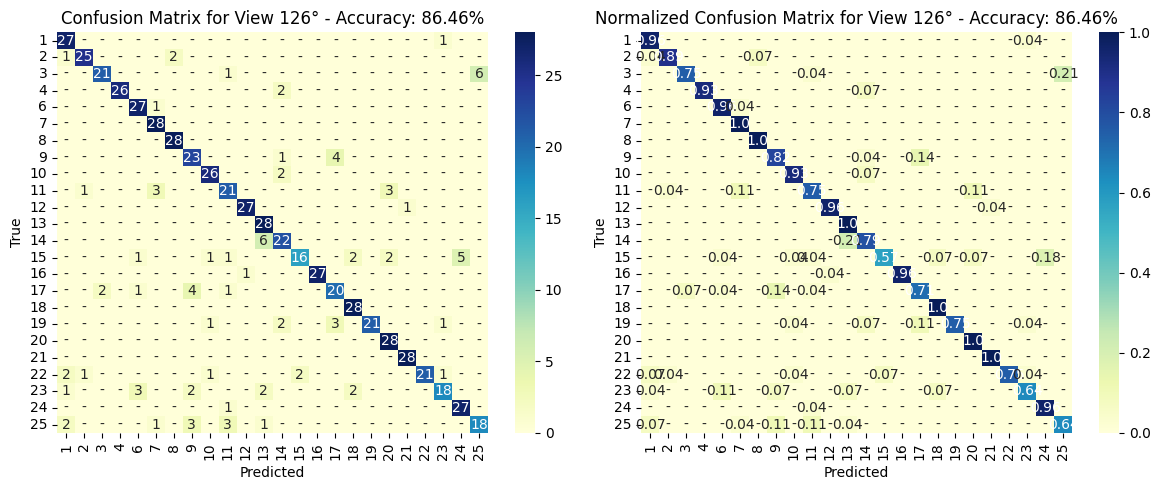

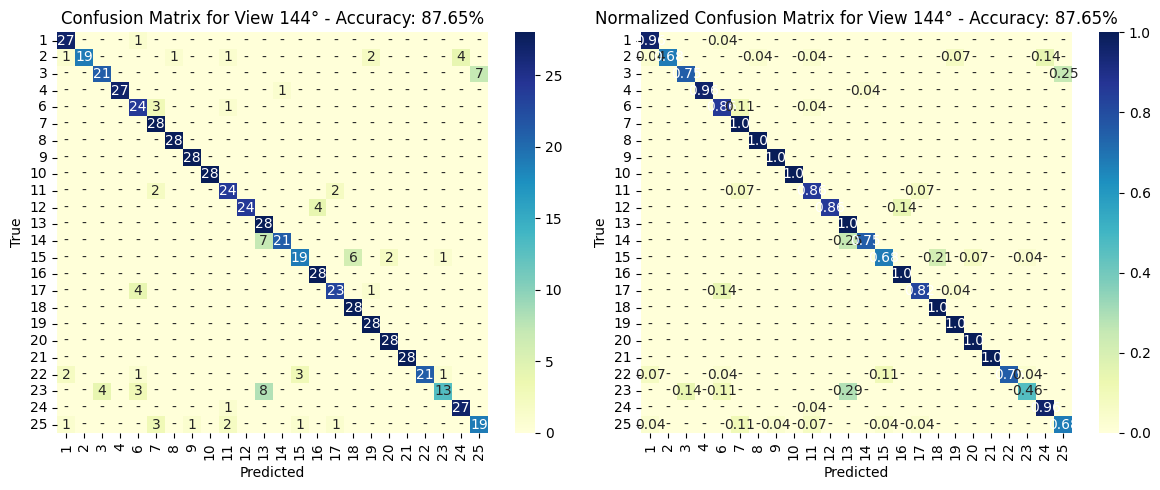

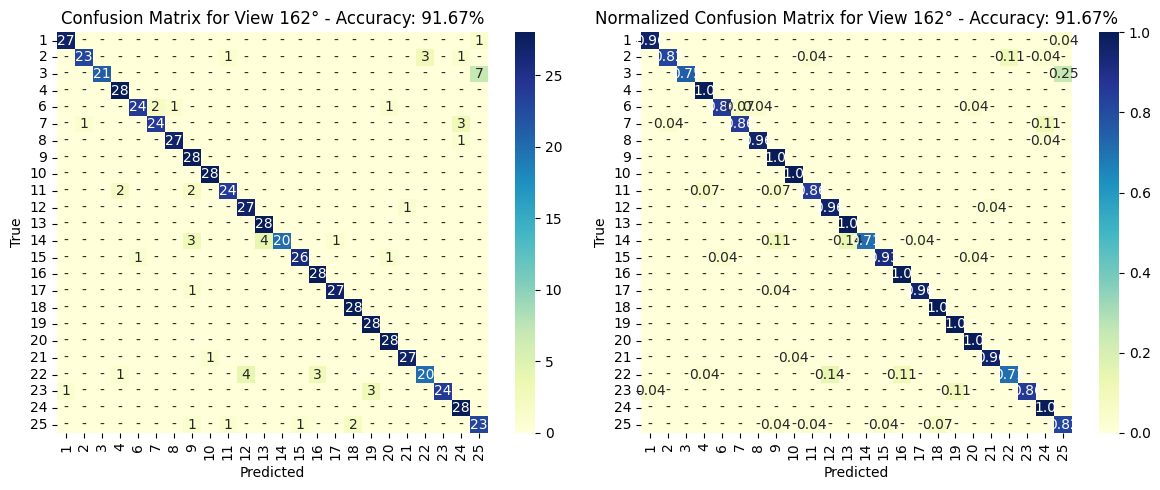

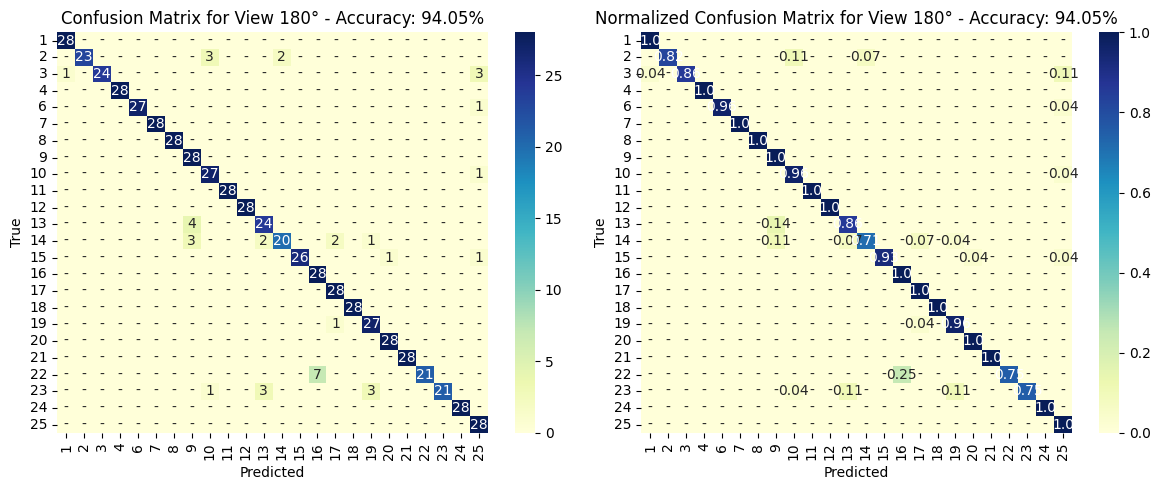

In [16]:
# Sử dụng hàm đã sửa để vẽ confusion matrix cho từng góc

view_acc = []
for v in views:
    y_test_view = y_test_by_view[views.index(v)]
    y_pred_view = y_pred_by_view[views.index(v)]

    acc = accuracy_score(y_test_view, y_pred_view)  # chuyển sang %
    view_acc.append(acc)
    draw_confusion_matrix(
        y_test_view,
        y_pred_view,
        class_names,
        title=f'Confusion Matrix for View {v}° - Accuracy: {acc*100:.2f}%')


View có độ chính xác cao nhất: 180 độ — Độ chính xác: 94.05%
View có độ chính xác thấp nhất: 108 độ — Độ chính xác: 84.08%


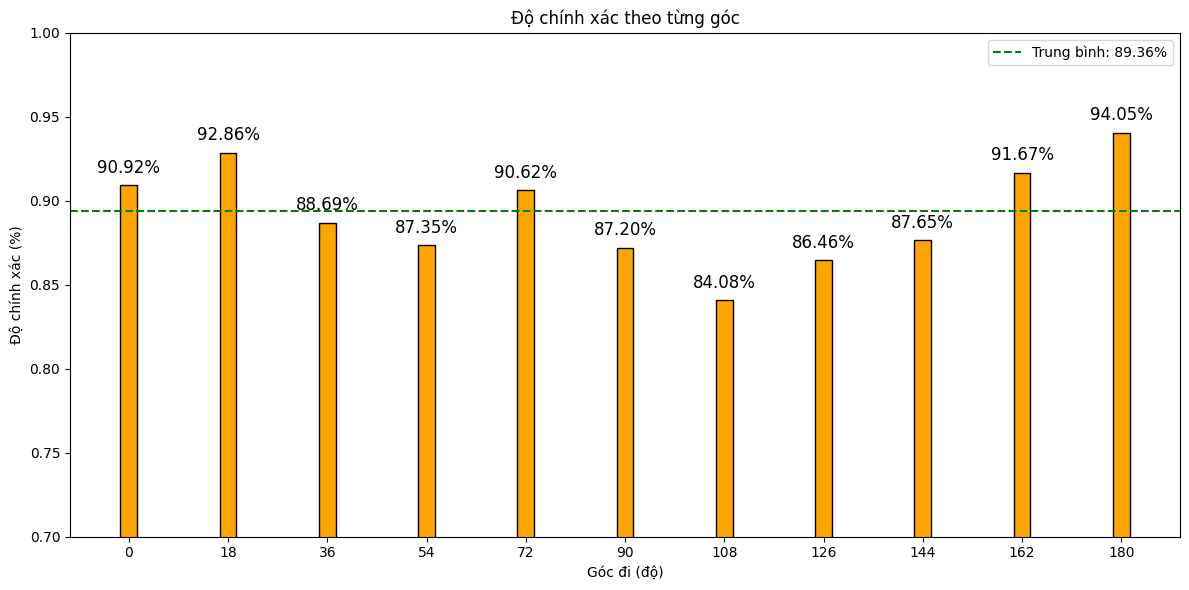

In [18]:
# Tìm chỉ số (index) của view có độ chính xác cao nhất và thấp nhất
max_idx = view_acc.index(max(view_acc))
min_idx = view_acc.index(min(view_acc))

# Tìm giá trị view tương ứng
best_view = views[max_idx]
worst_view = views[min_idx]

# In kết quả
print(f'View có độ chính xác cao nhất: {best_view} độ — Độ chính xác: {view_acc[max_idx]*100:.2f}%')
print(f'View có độ chính xác thấp nhất: {worst_view} độ — Độ chính xác: {view_acc[min_idx]*100:.2f}%')

# Vẽ bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(views, view_acc, color='orange', edgecolor='black', width = 3)

# Vẽ đường thẳng thể hiện accuracy trung bình
plt.axhline(mean_accuracy, color='green', linestyle='--', label=f'Trung bình: {mean_accuracy*100:.2f}%')

# Gắn nhãn trục
plt.xlabel('Góc đi (độ)')
plt.ylabel('Độ chính xác (%)')
plt.title('Độ chính xác theo từng góc')
plt.xticks(views)
plt.ylim(0.7, 1.0) 
plt.legend()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height*100:.2f}%', 
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## Biểu diễn dữ liệu đặc trưng PCA và t-SNE

### vẽ một cái 2d và 3d của PCA, sau đó thử sử dụng Sammon Mapping

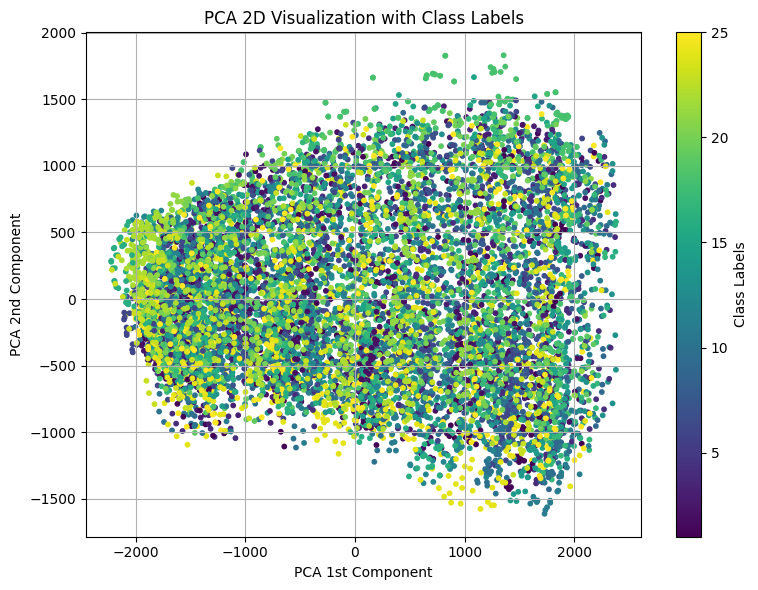

C:\Users\HUY\AppData\Local\Temp\ipykernel_3716\770645781.py:20: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter2d, label='Class Labels')


<Figure size 640x480 with 0 Axes>

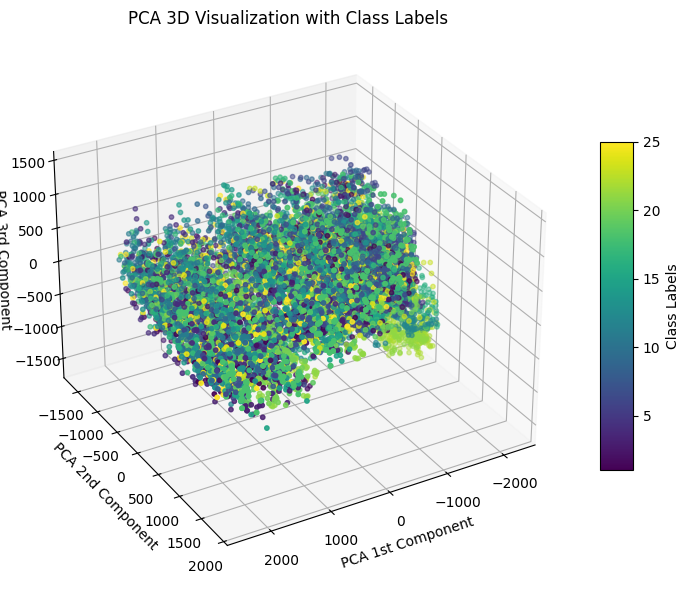

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

pca3d = x_train[:, :3]  # PCA 3 thành phần

# --- Biểu đồ 2D ---
plt.figure(figsize=(8, 6))
scatter2d = plt.scatter(
    pca3d[:, 0], pca3d[:, 1],
    c=y_train, cmap='viridis', s=10
)
plt.xlabel('PCA 1st Component')
plt.ylabel('PCA 2nd Component')
plt.title('PCA 2D Visualization with Class Labels')
plt.colorbar(scatter2d, label='Class Labels')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.colorbar(scatter2d, label='Class Labels')

# --- Biểu đồ 3D ---
fig = plt.figure(figsize=(8, 6))
ax3d = fig.add_subplot(111, projection='3d')
scatter3d = ax3d.scatter(
    pca3d[:, 0], pca3d[:, 1], pca3d[:, 2],
    c=y_train, cmap='viridis', s=10
)
ax3d.set_xlabel('PCA 1st Component')
ax3d.set_ylabel('PCA 2nd Component')
ax3d.set_zlabel('PCA 3rd Component')
ax3d.set_title('PCA 3D Visualization with Class Labels')
ax3d.view_init(elev=30, azim=60)
cbar3d = fig.colorbar(scatter3d, ax=ax3d, shrink=0.6, aspect=10)
cbar3d.set_label('Class Labels')
plt.tight_layout()
plt.show()


### vẽ 1 cái 2d và 3d cho t-SNE, sau đó sử dụng Sammon Mapping

c:\Users\HUY\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


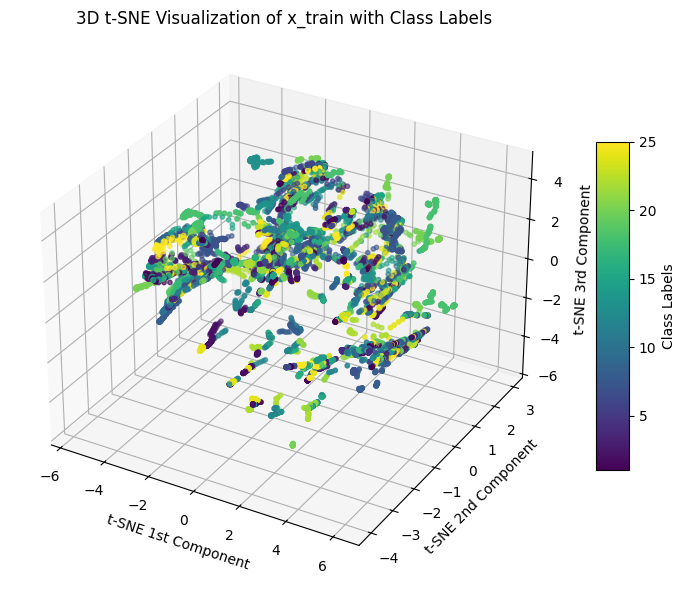

c:\Users\HUY\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


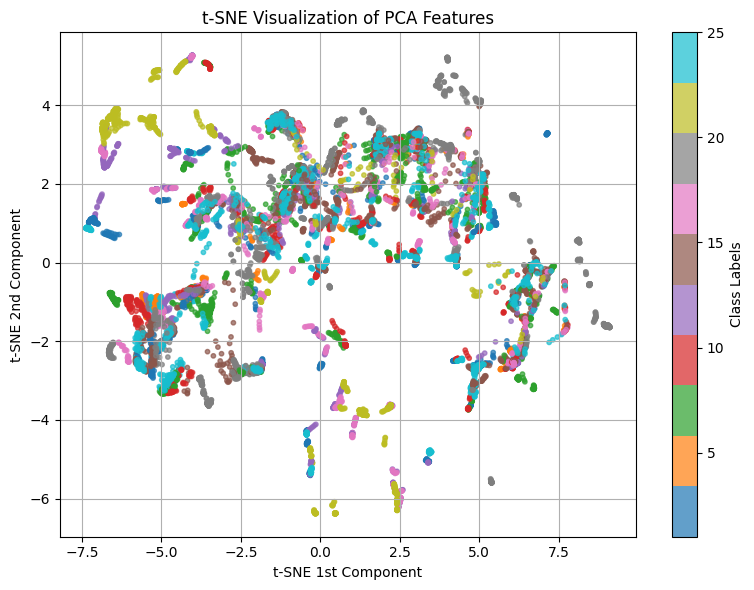

In [20]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Giảm chiều dữ liệu xuống 3 thành phần bằng t-SNE
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=10, n_iter=250)
x_train_tsne_3d = tsne_3d.fit_transform(x_train)

# Hiển thị dữ liệu t-SNE trên đồ thị 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    x_train_tsne_3d[:, 0], x_train_tsne_3d[:, 1], x_train_tsne_3d[:, 2],
    c=y_train, cmap='viridis', s=10
)

# Thêm colorbar để biểu diễn nhãn
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Class Labels')

# Gắn nhãn trục và tiêu đề
ax.set_xlabel('t-SNE 1st Component')
ax.set_ylabel('t-SNE 2nd Component')
ax.set_zlabel('t-SNE 3rd Component')
ax.set_title('3D t-SNE Visualization of x_train with Class Labels')

plt.tight_layout()
plt.show()

tsne_2d = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=250)
x_train_tsne_2d = tsne_2d.fit_transform(x_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x_train_tsne_2d[:, 0], x_train_tsne_2d[:, 1],
    c=y_train, cmap='tab10', s=10, alpha=0.7
)
plt.colorbar(scatter, label='Class Labels')
plt.title('t-SNE Visualization of PCA Features')
plt.xlabel('t-SNE 1st Component')
plt.ylabel('t-SNE 2nd Component')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def sammon_mapping(X, n_components=2, max_iter=50, tol=1e-1):
    D = squareform(pdist(X)) + 1e-1  # avoid division by zero
    scale = 0.5 / D.sum()

    # Initialize with PCA
    
    from sklearn.decomposition import PCA
    init = PCA(n_components=n_components).fit_transform(X)
    Y = init.copy()
    Y = init.copy()

    def sammon_error(Y_flat):
        Y = Y_flat.reshape(X.shape[0], n_components)
        d = squareform(pdist(Y)) + 1e-1
        delta = ((D - d)**2 / D).sum()
        return scale * delta

    result = minimize(
        sammon_error,
        Y.ravel(),
        method='L-BFGS-B',
        options={'maxiter': max_iter, 'disp': True, 'ftol': tol}
    )

    return result.x.reshape(X.shape[0], n_components)


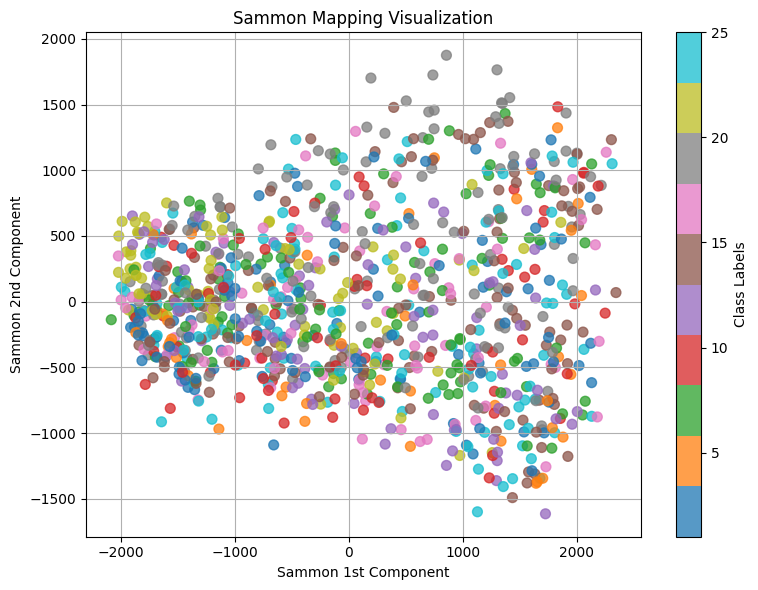

In [22]:
# Giả sử bạn có x_train và y_train

idx = np.random.choice(len(x_train), 1000, replace=False)
x_small = x_train[idx]
y_small = y_train[idx]

x_sammon = sammon_mapping(x_small, n_components=2)

# Vẽ biểu đồ kết quả
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_sammon[:, 0], x_sammon[:, 1], c=y_small, cmap='tab10', s=50, alpha=0.75)
plt.colorbar(scatter, label='Class Labels')
plt.title("Sammon Mapping Visualization")
plt.xlabel("Sammon 1st Component")
plt.ylabel("Sammon 2nd Component")
plt.grid(True)
plt.tight_layout()
plt.show()


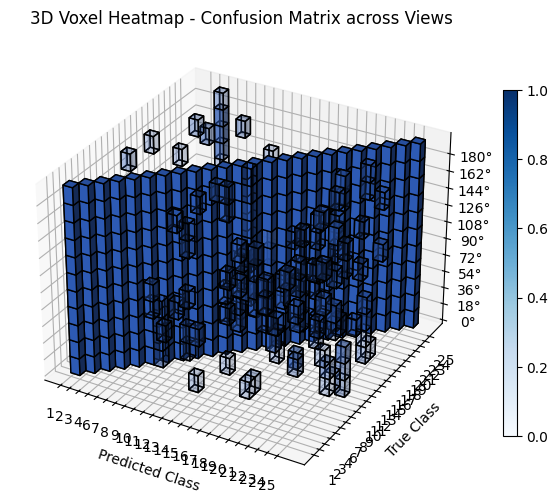

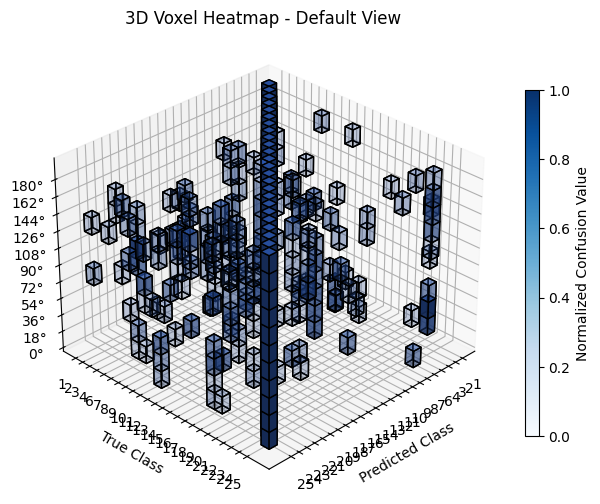

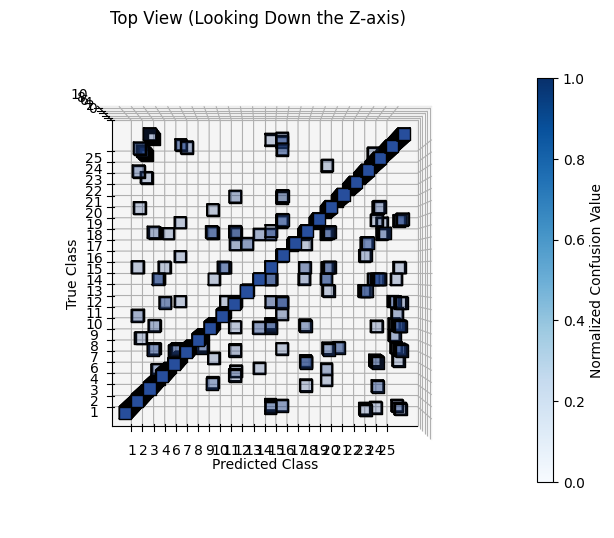

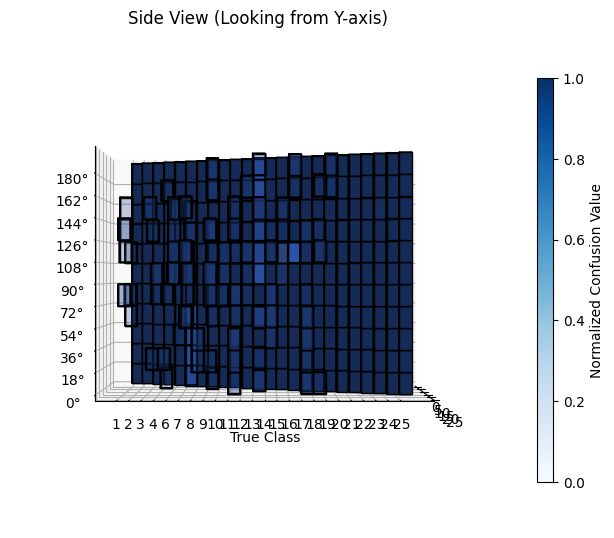

In [23]:
import matplotlib as mpl

def heatmap_3d(y_test_by_view, y_pred_by_view):    
    # Kích thước của voxel grid
    n_class, n_view = len(class_names), len(views)

    # Tạo lưới voxel: shape (true, pred, view)
    voxel_data = np.zeros((n_class, n_class, n_view))
    colors = np.empty(voxel_data.shape + (4,), dtype=np.float32)  # RGBA

    # Lấp dữ liệu confusion matrix vào voxel
    for v_idx, view in enumerate(views):
        # cm = confusion_matrix(y_test_all[v_idx], y_pred_all[v_idx], labels=class_names)
        cm = confusion_matrix(y_test_by_view[v_idx], y_pred_by_view[v_idx], labels=class_names)
        
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        for i in range(n_class):        # true class
            for j in range(n_class):    # predicted class
                value = cm_norm[i, j]
                voxel_data[i, j, v_idx] = value > 0.05  # chỉ hiện khối nếu đủ lớn
                alpha = min(value * 2, 1.0)
                colors[i, j, v_idx] = [0.2, 0.4, 0.8, alpha]  # xanh lam với độ trong suốt

    # Vẽ voxel heatmapheatmap
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')

    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('3D Voxel Heatmap - Confusion Matrix across Views')

    # Tạo colorbar và sử dụng color bar cho độ trong suốt (alpha value)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])  # Cần thiết để colorbar hoạt động
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25)

    plt.show()
    
    # Đồ thị góc chính diện
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('3D Voxel Heatmap - Default View')
    ax.view_init(elev=30, azim=45)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

    # Đồ thị nhìn từ trên cao xuống
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_title('Top View (Looking Down the Z-axis)')
    ax.view_init(elev=90, azim=-90)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

    # Đồ thị nhìn từ bên hông qua
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_ylabel('True Class')
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('Side View (Looking from Y-axis)')
    ax.view_init(elev=0, azim=0)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

heatmap_3d(y_test_by_view, y_pred_by_view)